# IMAGE CLASSIFICATION WITH CIFAR-10 

## 1. Data Preparation 

### Import standard libraries

In [2]:
import torch 
import torchvision.transforms as transforms

from torchvision import datasets 
from torch.utils.data import ConcatDataset, DataLoader, random_split

torch.manual_seed(42) 

import numpy as np 
import matplotlib.pyplot as plt 

### Define classes and data augmentation methods 

We will implement:

* Standard normalization
* Shifitng: Randomly shifting the images up/down and left/right by within 10% 
* Rotating: Randomly rotate the images by some angles 
* Flipping: Horizontal flip the images 
* Adding Noise: Randomly add some small Gaussian noise to the images. 

After augmenting the data, we will have a total of $50,000\times5=250,000$ images for our training dataset.

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 
           'ship', 'truck')

# Define transformations 

# 1. Normalization 
transform1 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# 2. Shifting 
transform2 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))]
)

# 3. Rotation
transform3 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomRotation(degrees=(0,180))]
)

# 4. Horizontal Flip 
transform4 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomHorizontalFlip(p=0.5)]
)

# 5. Gaussian Noise 
def gauss_noise_tensor(img):
    
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32) 

    sigma = 1.0 
    
    out = img + sigma * torch.randn_like(img) 

    if out.dtype != dtype:
        out = out.to(dtype) 

    return out 

transform5 = transforms.Compose(
    [transforms.PILToTensor(),
     gauss_noise_tensor,
     transforms.ConvertImageDtype(torch.float32),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Combine the transformation list 
transform_list = [transform2, transform3, transform4, transform5] 
        

### Load the data and apply data augmentation 

Since we are attempting to implement Early Stopping, we need a validating dataset. Instead of concatenating all 250,000 images as before, we will randomly split the first transformed dataset (`ToTensor()` and `Normalize()`) to get 20,000 images for validation (40% of the dataset). As a result, we will have $50,000\times4 + 30,000 = 230,000$ images for training and 20,000 images for validation. 

In [4]:
dataset_1 = datasets.CIFAR10(root = '../Data/',
                           train = True,
                           download = True,
                           transform = transform1)
# Split the dataset 
val_size = 20000
train_size = len(dataset_1) - val_size
trainset_1, valid_dataset = random_split(dataset_1,
                                         lengths=[train_size, val_size])
print(len(trainset_1))
print(len(valid_dataset))

Files already downloaded and verified
30000
20000


In [6]:
# Create an empty data set 
augmented_dataset = [] 

# Download and apply transformation 
for t in transform_list:
    augmented_dataset.append(datasets.CIFAR10(root = '../Data/',
                                              train = True,
                                              download = True,
                                              transform = t))
cifar10_trainset = ConcatDataset(augmented_dataset, trainset_1) 

# Download the test set and normalize the data only
cifar10_testset = datasets.CIFAR10(root = '../Data/',
                                   train = False,
                                   download = True, 
                                   transform = transform1)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [14]:
print(augmented_dataset)
# print(trainset_1)

### Visualize the dataset 

In [5]:
%matplotlib inline 

def data_viz(img):

    img = img / 2 + 0.5  # Unnormalize 
    npimg = img.numpy()

    return np.transpose(npimg, (1, 2, 0))

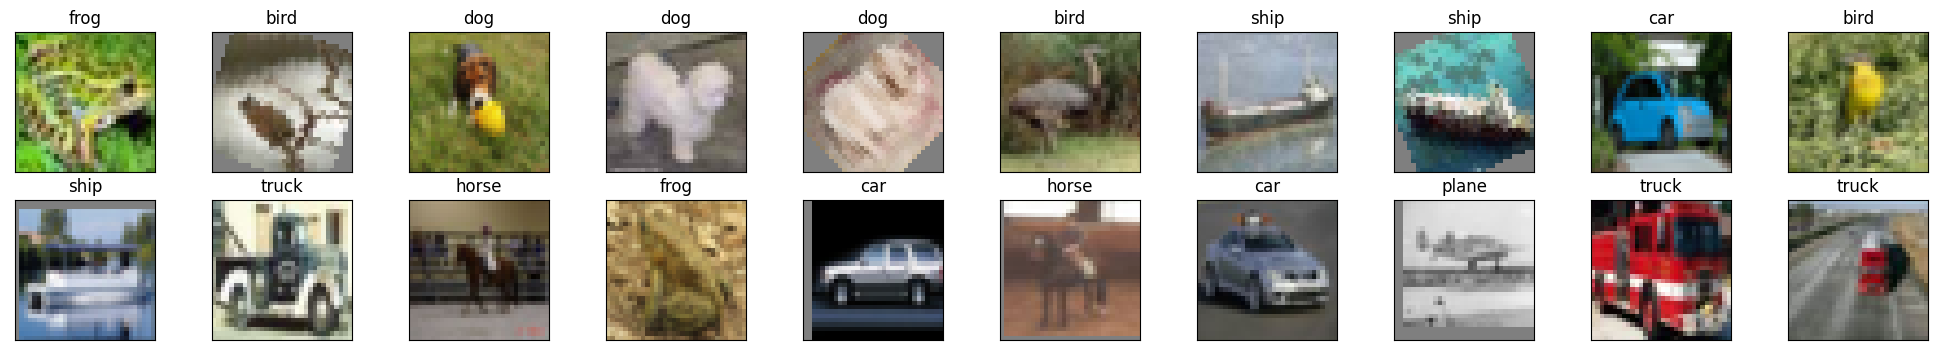

In [6]:
# DataLoader 
BATCH_SIZE = 128 

train_loader = DataLoader(cifar10_trainset, 
                          batch_size = BATCH_SIZE,
                          shuffle = True)
test_loader = DataLoader(cifar10_testset,
                         batch_size = BATCH_SIZE,
                         shuffle = False)

# Show 20 images from the training set 
dataiter = iter(train_loader)
images, labels = next(dataiter)

fig = plt.figure(figsize=(25, 4))

for i in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), i+1, xticks=[], yticks=[])
    plt.imshow(data_viz(images[i])) 
    ax.set_title(classes[labels[i]])

### Count the number of images for each class

In [45]:
class_count = {}
for _, index in cifar10_trainset:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
class_count

{'frog': 25000,
 'truck': 25000,
 'deer': 25000,
 'car': 25000,
 'bird': 25000,
 'horse': 25000,
 'ship': 25000,
 'cat': 25000,
 'dog': 25000,
 'plane': 25000}

## 2. Define `train()` and `test()` Functions

### Training function 

In [8]:
def train_classifier(dataloader, model, loss_fn, optimizer, device):
    '''
    Function to train the model

    '''

    model.train() 
    running_loss = [] 

    for batch , (images, labels) in enumerate(dataloader):

        # Forward pass: Compute prediction and Loss 
        images, labels = images.to(device), labels.to(device) 
        preds = model(images) 
        loss = loss_fn(preds, labels) 
        running_loss.append(loss.item())

        # Back-Propagation
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 

    return np.average(running_loss) 


### Evaluating function

In [27]:
def test_classifier(dataloader, model, loss_fn, device):

    ''' 
    Function to test the trained model. Print out the average accuracy as well as accuracy for each class in the dataset.
    
    '''
    size = len(dataloader.dataset) 
    test_loss = [] 
    accuracy = 0 
    correct_preds = {classname: 0 for classname in classes} 
    total_preds = {classname: 0 for classname in classes} 

    with torch.no_grad():

        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device) 
            preds = model(images) 
            test_loss.append(loss_fn(preds, labels).item())
            accuracy += (preds.argmax(1)==labels).type(torch.float).sum().item()

            # Calculate for each class
            for label, pred in zip(labels, preds.argmax(1)):
                if label == pred:
                    correct_preds[classes[label]] += 1
                total_preds[classes[label]] += 1
        
    test_loss = np.average(test_loss)
    accuracy /= size
    print(f"Evaluation: \n Accuracy: {(100*accuracy):>0.1f}% \t Avg Loss: {test_loss:>8f} \n")

    # Print accuracy for each class
    for classname, correct_count in correct_preds.items():
        class_acc = 100 * float(correct_count) / total_preds[classname] 
        print(f"Accuracy for class {classname:5s} is {class_acc:.1f}%")


### Function to plot the results

In [10]:
def plot_history(data):
    plt.plot(data)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Losses over each Epoch")
    plt.show()

### Function to save checkpoint for every epoch

In [17]:
def save_checkpoint(epoch, model, loss_fn, optimizer, epoch_loss, path):
    """ 
    Save model checkpoint. 
    
    :param epoch     : Current epoch number
    :param model     : Model 
    :param optimizer : Optimizer 
    :param loss_fn   : Loss function used 
    :param epoch_loss: Loss for each epoch upto 'epoch'
    :param filename  : Name for the checkpoint file
    
    """
    state = {'epoch': epoch,
             'model': model,
             'criterion': loss_fn,
             'optimizer': optimizer,
             'epoch_loss': epoch_loss}
    torch.save(state, path) 

## 3. Define Network Architecture 

In [11]:
import torch.nn as nn 
import torch.nn.functional as F 

class CifarCNN(nn.Module):
  
  def __init__(self, num_classes):
    super(CifarCNN, self).__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.fc_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=4*4*256, out_features=4096),
        nn.ReLU(),
        nn.Linear(in_features=4096, out_features=1024),
        nn.ReLU(),
        nn.Linear(in_features=1024, out_features=num_classes)
    )

  def forward(self, x):
    # TODO: define your forward function
    x = self.conv_block_1(x)  # (b, 64, 16, 16)
    x = self.conv_block_2(x)  # (b, 128, 8, 8)
    x = self.conv_block_3(x)  # (b, 256, 4, 4)
    x = F.softmax(self.fc_layer(x), dim=1)

    return x

### Verify the network 

In [12]:
# Set up device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) 

NUM_CLASSES = len(classes) 
model = CifarCNN(num_classes=NUM_CLASSES).to(device)

cuda


In [14]:
# Verify
input = torch.randn(1, 3, 32, 32) 
output = model(input.to(device))
print(output)

tensor([[0.0950, 0.0961, 0.0991, 0.1011, 0.1061, 0.1040, 0.1003, 0.1004, 0.1020,
         0.0960]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


### Define loss function and optimzier 

In [28]:
# Hyperparameters 
NUM_EPOCHS = 40 
LEARNING_RATE = 0.001
MOMENTUM = 0.9 
WEIGHT_DECAY = 5E-4 

# Loss function and optimizer 
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(),
                            lr = LEARNING_RATE,
                            momentum = MOMENTUM,
                            weight_decay = WEIGHT_DECAY)

## 4. Train Model 

In [29]:
import os 

filename = "cnn_cifar10.pth" 
checkpoint_dir = "../checkpoints/"
PATH = os.path.join(checkpoint_dir, filename)
print(PATH)

checkpoint_path = "../checkpoints/cnn_cifar10.pth" 

# Initialize untrained model if no checkpoint specified, otherwise, load model and resume training 
if checkpoint_path is None: 
    start_epoch = 0 
    model = CifarCNN(num_classes=NUM_CLASSES) 
    criterion = nn.CrossEntropyLoss() 
    optimizer = torch.optim.SGD(model.parameters(), 
                                lr = LEARNING_RATE, 
                                momentum = MOMENTUM,
                                weight_decay = WEIGHT_DECAY)
    epoch_loss = []  # Training from scratch 

else: 
    checkpoint = torch.load(checkpoint_path) 
    start_epoch = checkpoint['epoch'] + 1
    print(f"Load checkpoint from epoch {start_epoch}. \n") 
    model = checkpoint['model']
    criterion = checkpoint['criterion'] 
    optimizer = checkpoint['optimizer'] 
    epoch_loss = checkpoint['epoch_loss']

# Move model to default device 
model = model.to(device) 
criterion = criterion.to(device) 


../checkpoints/cnn_cifar10.pth
Load checkpoint from epoch 30. 



### Training 

Epoch: 31 	Training loss: 1.5802
Epoch: 32 	Training loss: 1.5791
Epoch: 33 	Training loss: 1.5775
Epoch: 34 	Training loss: 1.5745
Epoch: 35 	Training loss: 1.5730
Epoch: 36 	Training loss: 1.5724
Epoch: 37 	Training loss: 1.5706
Epoch: 38 	Training loss: 1.5694
Epoch: 39 	Training loss: 1.5678
Epoch: 40 	Training loss: 1.5661
Training Finishes!


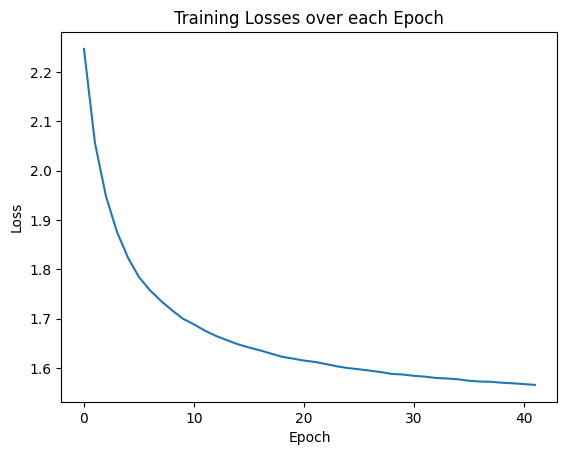

In [30]:
for epoch in range(start_epoch, NUM_EPOCHS):

    running_loss = train_classifier(dataloader = train_loader,
                                    model = model,
                                    loss_fn = criterion,
                                    optimizer = optimizer,
                                    device = device)
    # Append the average loss for each epoch
    epoch_loss.append(running_loss)
    # Save checkpoint for each epoch 
    save_checkpoint(epoch = epoch,
                    model = model,
                    loss_fn = criterion,
                    optimizer = optimizer,
                    epoch_loss = epoch_loss,
                    path = PATH)
    print(f"Epoch: {epoch+1} \t"
          f"Training loss: {running_loss:.4f}")
# Print out a message when the training finishes and plot the training loss
print("Training Finishes!")
plot_history(epoch_loss)

## 5. Evaluation 

In [23]:
# Load the checkpoint if necessary 
checkpoint_path = "../checkpoints/cnn_cifar10.pth"
checkpoint = torch.load(checkpoint_path) 
start_epoch = checkpoint['epoch'] + 1
print(f"Load checkpoint from epoch {start_epoch}. \n") 
model = checkpoint['model']
criterion = checkpoint['criterion']

Load checkpoint from epoch 30. 



In [31]:
# Evaluation 
print("----------- Evaluating ----------")
test_classifier(dataloader = test_loader,
                model = model,
                loss_fn = criterion,
                device = device)
print("Done!")

----------- Evaluating ----------
Evaluation: 
 Accuracy: 84.3% 	 Avg Loss: 1.616841 

Accuracy for class plane is 84.2%
Accuracy for class car   is 92.5%
Accuracy for class bird  is 76.8%
Accuracy for class cat   is 68.7%
Accuracy for class deer  is 85.4%
Accuracy for class dog   is 81.6%
Accuracy for class frog  is 88.3%
Accuracy for class horse is 84.2%
Accuracy for class ship  is 90.7%
Accuracy for class truck is 90.8%
Done!
